In [508]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,StandardScaler, MinMaxScaler, RobustScaler,OrdinalEncoder, LabelEncoder, FunctionTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.decomposition import PCA
import seaborn as sns

In [509]:
df=pd.read_csv('data.csv')

In [510]:
df.head()

,customer_id,birth_year,education_level,marital_status,annual_income,num_children,num_teenagers,signup_date,days_since_last_purchase,has_recent_complaint,...,num_web_purchases,num_catalog_purchases,num_store_purchases,web_visits_last_month,accepted_campaign_1,accepted_campaign_2,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_last_campaign
0,5524,1957,Graduation,Single,58138.0,0,0.0,4/9/2012,58,0,...,8,10,4,7,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1.0,8/3/2014,38,0,...,1,1,2,5,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0.0,21-08-2013,26,0,...,8,2,10,4,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0.0,10/2/2014,26,0,...,2,0,4,6,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0.0,19-01-2014,94,0,...,5,3,6,5,0,0,0,0,0,0


In [511]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               2240 non-null   int64  
 1   birth_year                2240 non-null   int64  
 2   education_level           2199 non-null   object 
 3   marital_status            2240 non-null   object 
 4   annual_income             2173 non-null   float64
 5   num_children              2240 non-null   int64  
 6   num_teenagers             2196 non-null   float64
 7   signup_date               2240 non-null   object 
 8   days_since_last_purchase  2240 non-null   int64  
 9   has_recent_complaint      2240 non-null   int64  
 10  spend_wine                2240 non-null   int64  
 11  spend_fruits              2240 non-null   int64  
 12  spend_meat                2240 non-null   int64  
 13  spend_fish                2240 non-null   int64  
 14  spend_sw

In [512]:
df.isnull().sum()

customer_id                  0
birth_year                   0
education_level             41
marital_status               0
annual_income               67
num_children                 0
num_teenagers               44
signup_date                  0
days_since_last_purchase     0
has_recent_complaint         0
spend_wine                   0
spend_fruits                 0
spend_meat                   0
spend_fish                   0
spend_sweets                 0
spend_gold                   0
num_discount_purchases       0
num_web_purchases            0
num_catalog_purchases        0
num_store_purchases          0
web_visits_last_month        0
accepted_campaign_1          0
accepted_campaign_2          0
accepted_campaign_3          0
accepted_campaign_4          0
accepted_campaign_5          0
accepted_last_campaign       0
dtype: int64

In [513]:
df.drop(['customer_id','signup_date'], axis=1, inplace=True)

In [514]:
def fetuere_engineering(df) :
   df = df.copy()
   current_year = datetime.now().year
   df['age'] = current_year - df['birth_year']
   df.loc[df['age'] > 100, 'age'] = np.nan
   spend_cols = [c for c in df.columns if c.startswith('spend_')]
   if len(spend_cols) > 0:
        df['total_spend'] = df[spend_cols].sum(axis=1)
   accepted_campaign=[c for c in df.columns if c.startswith('accepted_')]
   df['num_accepted_campaigns'] = df[accepted_campaign].sum(axis=1) if len(accepted_campaign)>0 else np.nan
   purchase_cols = [c for c in df.columns if c.startswith('num_') and 'visits' not in c]
   df['total_purchases'] = df[purchase_cols].sum(axis=1) if len(purchase_cols)>0 else np.nan
   if 'num_web_purchases' in df.columns and 'total_purchases' in df.columns:
        df['online_ratio'] = df['num_web_purchases'] / (df['total_purchases'].replace(0, np.nan))
   return df



In [515]:
df=fetuere_engineering(df)

In [516]:
df.isnull().sum()

birth_year                   0
education_level             41
marital_status               0
annual_income               67
num_children                 0
num_teenagers               44
days_since_last_purchase     0
has_recent_complaint         0
spend_wine                   0
spend_fruits                 0
spend_meat                   0
spend_fish                   0
spend_sweets                 0
spend_gold                   0
num_discount_purchases       0
num_web_purchases            0
num_catalog_purchases        0
num_store_purchases          0
web_visits_last_month        0
accepted_campaign_1          0
accepted_campaign_2          0
accepted_campaign_3          0
accepted_campaign_4          0
accepted_campaign_5          0
accepted_last_campaign       0
age                          3
total_spend                  0
num_accepted_campaigns       0
total_purchases              0
online_ratio                 3
dtype: int64

In [517]:
df.dropna(inplace=True)

In [518]:
numeric_feature = df.select_dtypes(include=[np.number]).columns.tolist()

In [519]:
cat_feature = df.select_dtypes(include=[np.object_]).columns.tolist()

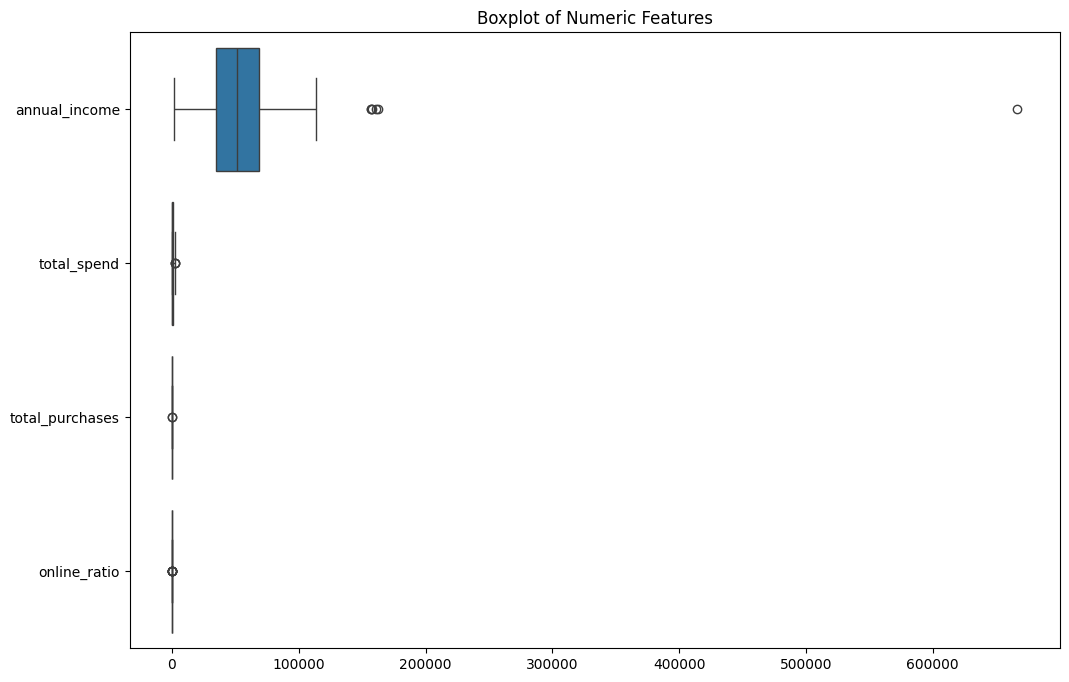

In [520]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[['annual_income','total_spend','total_purchases','online_ratio']], orient='h')
plt.title('Boxplot of Numeric Features')
plt.show()

In [521]:
X_outlier = df[['annual_income','total_spend','total_purchases','online_ratio']]

# Calculate Q1, Q3, IQR for all columns
Q1 = X_outlier.quantile(0.25)
Q3 = X_outlier.quantile(0.75)
IQR = Q3 - Q1

outlier_condition = ((X_outlier < (Q1 - 1.5 * IQR)) | (X_outlier > (Q3 + 1.5 * IQR)))
X_outlier = X_outlier[outlier_condition.any(axis=1)]

outlier_count = outlier_condition.any(axis=1).sum()

outlier_count


18

In [522]:
# create boolean mask for rows that are outliers in any of the selected columns
outlier_mask = outlier_condition.any(axis=1)
# keep only non-outlier rows
df = df.loc[~outlier_mask].reset_index(drop=True)

In [523]:
scaler = MinMaxScaler()
df[numeric_feature] = scaler.fit_transform(df[numeric_feature])

In [524]:
df['marital_status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [525]:
df['education_level'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [526]:
df['education_level'] = df['education_level'].map({'2n Cycle':1, 'Basic':2, 'Graduation':3, 'Master':4, 'PhD':5})
df['marital_status'] = df['marital_status'].map({'Single':1, 'Married':2, 'Divorced':3, 'Widow':4, 'Together':5, 'Absurd':6, 'YOLO':7, 'Alone':8})

In [527]:
imputer = KNNImputer(n_neighbors=3)
df_imputed = imputer.fit_transform(df)

In [528]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df)
pca_components.shape
pca.explained_variance_ratio_

array([0.46226739, 0.25887285])

c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:14

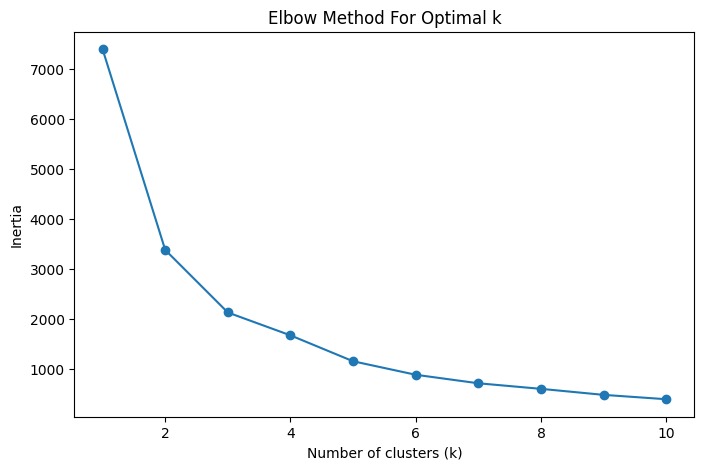

In [529]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_components)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [530]:
silhouette_scores = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_components)
    score = silhouette_score(pca_components, cluster_labels)
    silhouette_scores.append(score)
print(silhouette_scores)



c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:14

[0.553260207499402, 0.5137040658544632, 0.5382988126432827, 0.551535733500838, 0.5895634159864479, 0.5998047388653687, 0.6400772153650643, 0.66757055160166, 0.7193600372859058, 0.7491466473145298, 0.76002538294419, 0.784902286833825, 0.8021188898906234, 0.8200901841141846, 0.8544415101383909, 0.8798449885735605, 0.8863601411336628, 0.8942314413888295]


In [531]:
# K-Means Clustering
X=df[numeric_feature]
kmeans = KMeans(n_clusters=6, random_state=42)
df['cluster']=kmeans.fit_predict(X)

c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


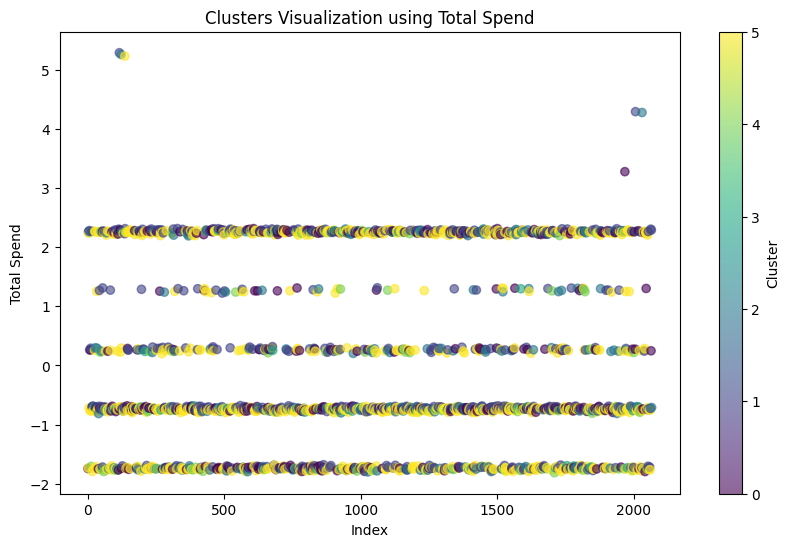

In [532]:
#visualization of clusters
plt.figure(figsize=(10, 6))
# plot index vs total_spend (use a single numeric column, not the whole numeric_feature list)
plt.scatter(df.index, pca_components[:, 0], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Total Spend')
plt.title('Clusters Visualization using Total Spend')
plt.colorbar(label='Cluster')
plt.show()

In [533]:
# DBSCAN Clustering code here

In [534]:
X_fetuer=df[numeric_feature + cat_feature]
y_fetuer=df['cluster']
X_train, X_test, y_train, y_test = train_test_split(X_fetuer, y_fetuer, test_size=0.2, random_state=42, stratify=y_fetuer)


In [535]:
Rmodel=RandomForestClassifier(n_estimators=200, random_state=42)
Rmodel.fit(X_train, y_train)
y_pred = Rmodel.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        74
           1       0.89      0.92      0.90        97
           2       0.98      0.98      0.98        41
           3       1.00      1.00      1.00        13
           4       0.95      1.00      0.98        20
           5       0.98      0.96      0.97       169

    accuracy                           0.95       414
   macro avg       0.96      0.96      0.96       414
weighted avg       0.95      0.95      0.95       414



In [536]:
X_train, X_test, y_train, y_test = train_test_split(X_fetuer, y_fetuer, test_size=0.2, random_state=42, stratify=y_fetuer)


In [537]:
Lmodel=LogisticRegression(max_iter=200,random_state=42)
Lmodel.fit(X_train, y_train)
y_pred = Lmodel.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[ 72   2   0   0   0   0]
 [  3  91   0   0   0   3]
 [  0   0  41   0   0   0]
 [  0   0   0  13   0   0]
 [  0   0   0   0  20   0]
 [  0   0   0   0   0 169]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        74
           1       0.98      0.94      0.96        97
           2       1.00      1.00      1.00        41
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        20
           5       0.98      1.00      0.99       169

    accuracy                           0.98       414
   macro avg       0.99      0.99      0.99       414
weighted avg       0.98      0.98      0.98       414



In [538]:
X_train, X_test, y_train, y_test = train_test_split(X_fetuer, y_fetuer, test_size=0.2, random_state=42, stratify=y_fetuer)


In [539]:
scores=[]
for depth in [1,2,3,4,5,6,7]:
  for s in [3,4,5,6,7,8,9,10]:
    TModel=DecisionTreeClassifier(max_depth=depth,min_samples_leaf=s)
    TModel.fit(X_train,y_train)
    Acc=accuracy_score(y_test,TModel.predict(X_test))
    scores.append((depth,s,Acc))
print(scores)

[(1, 3, 0.572463768115942), (1, 4, 0.572463768115942), (1, 5, 0.572463768115942), (1, 6, 0.572463768115942), (1, 7, 0.572463768115942), (1, 8, 0.572463768115942), (1, 9, 0.572463768115942), (1, 10, 0.572463768115942), (2, 3, 0.6714975845410628), (2, 4, 0.6714975845410628), (2, 5, 0.6714975845410628), (2, 6, 0.6714975845410628), (2, 7, 0.6714975845410628), (2, 8, 0.6714975845410628), (2, 9, 0.6714975845410628), (2, 10, 0.6714975845410628), (3, 3, 0.8140096618357487), (3, 4, 0.8140096618357487), (3, 5, 0.8140096618357487), (3, 6, 0.8140096618357487), (3, 7, 0.8140096618357487), (3, 8, 0.8140096618357487), (3, 9, 0.8140096618357487), (3, 10, 0.8140096618357487), (4, 3, 0.8381642512077294), (4, 4, 0.8405797101449275), (4, 5, 0.8381642512077294), (4, 6, 0.8381642512077294), (4, 7, 0.8381642512077294), (4, 8, 0.8381642512077294), (4, 9, 0.8381642512077294), (4, 10, 0.8381642512077294), (5, 3, 0.8888888888888888), (5, 4, 0.8888888888888888), (5, 5, 0.8888888888888888), (5, 6, 0.89130434782608

In [540]:

DT_model=DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=7)
DT_model.fit(X_train, y_train)
y_pred = DT_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy_score for DecisionTreeClassifier : ',accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 67   6   1   0   0   0]
 [ 19  72   0   0   0   6]
 [  0   0  38   0   3   0]
 [  0   0   0  13   0   0]
 [  0   0   0   0  20   0]
 [  2   6   0   0   0 161]]
accuracy_score for DecisionTreeClassifier :  0.8961352657004831
              precision    recall  f1-score   support

           0       0.76      0.91      0.83        74
           1       0.86      0.74      0.80        97
           2       0.97      0.93      0.95        41
           3       1.00      1.00      1.00        13
           4       0.87      1.00      0.93        20
           5       0.96      0.95      0.96       169

    accuracy                           0.90       414
   macro avg       0.90      0.92      0.91       414
weighted avg       0.90      0.90      0.90       414



In [541]:
X_train, X_test, y_train, y_test = train_test_split(X_fetuer, y_fetuer, test_size=0.2, random_state=42, stratify=y_fetuer)


In [542]:
from sklearn.svm import SVC
svm_model=SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[ 70   3   1   0   0   0]
 [  1  93   0   0   0   3]
 [  0   0  41   0   0   0]
 [  0   0   0  13   0   0]
 [  0   0   1   0  19   0]
 [  0   0   0   0   0 169]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        74
           1       0.97      0.96      0.96        97
           2       0.95      1.00      0.98        41
           3       1.00      1.00      1.00        13
           4       1.00      0.95      0.97        20
           5       0.98      1.00      0.99       169

    accuracy                           0.98       414
   macro avg       0.98      0.98      0.98       414
weighted avg       0.98      0.98      0.98       414



In [543]:
X_train, X_test, y_train, y_test = train_test_split(X_fetuer, y_fetuer, test_size=0.2, random_state=42, stratify=y_fetuer)


In [544]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('lr', Lmodel), ('dt', DT_model), ('nb', Rmodel),('svm', svm_model)],
    voting='hard',
)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[ 73   0   1   0   0   0]
 [  6  91   0   0   0   0]
 [  0   0  41   0   0   0]
 [  0   0   0  13   0   0]
 [  0   0   0   0  20   0]
 [  0   2   0   0   0 167]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        74
           1       0.98      0.94      0.96        97
           2       0.98      1.00      0.99        41
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        20
           5       1.00      0.99      0.99       169

    accuracy                           0.98       414
   macro avg       0.98      0.99      0.98       414
weighted avg       0.98      0.98      0.98       414

